# Feature Importances and Comparison Tables by Metrice Scores

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from impyute.imputation.cs import fast_knn
import pickle

# Scores
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import make_scorer

# Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

# Ensemble models
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier

# Ignoring Errors
import warnings
warnings.simplefilter('ignore')

In [2]:
param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
scoring = make_scorer(roc_auc_score)
def gsearch(classifier, X_train, y_train, param_grid, scoring=scoring):
    gs = GridSearchCV(estimator=classifier,
                      param_grid=param_grid, 
                      scoring=scoring,
                      cv=5,
                      n_jobs=-1)
    gs = gs.fit(X_train, y_train)
    return (gs.best_score_, gs.best_params_, gs.best_estimator_)

def collect_scores(classifier, X_train, X_test, y_train, y_test):
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    y_prob = classifier.predict_proba(X_test)[:,1]
    auc = roc_auc_score(y_test, y_prob)
    tn, fp, fn, tp = confusion_matrix(y_true=y_test, y_pred=y_pred).ravel()
    
    tpr = tp/(tp + fn)
    tnr = tn/(fp + tn)
    ppv = tp/(tp + fp)
    npv = tn/(tn + fn)
    plr = tpr/(1 - tnr)
    nlr = (1 - tpr)/tnr
    y_test_size = y_test.shape[0]
    fn = fn/y_test_size
    fp = fp/y_test_size
    return [tpr, tnr, fn, fp, ppv, npv, plr, nlr, auc]

In [3]:
def best_estimator(X, y):
    best_lr, best_svm, best_rf = [0, 0], [0, 0], [0, 0]

    pipe_lr = Pipeline([['sc', StandardScaler()], ['clf', LogisticRegression(n_jobs=-1, random_state=1)]])
    pipe_svm = Pipeline([['sc', StandardScaler()], ['clf', SVC(probability=True, random_state=1)]])
    rf = RandomForestClassifier(random_state=1, n_jobs=-1)

    lr_grid = [{'clf__C': param_range,
            'clf__penalty': ['l1','l2']}]

    svm_grid = [{'clf__C': param_range,
                'clf__kernel': ['rbf','sigmoid']}]
    
    rf_grid = [{
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]}]
    
    if X.shape[1] < 3:
        rf_grid = [{
        'bootstrap': [True],
        'max_depth': [80, 90, 100, 110],
        'max_features': ['auto'],
        'min_samples_leaf': [3, 4, 5],
        'min_samples_split': [8, 10, 12],
        'n_estimators': [100, 200, 300, 1000]}]

    kf = StratifiedKFold(10, random_state=1)
    for train_index, test_index in kf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        lr = gsearch(pipe_lr, X_train, y_train, lr_grid)
        svm = gsearch(pipe_svm, X_train, y_train, svm_grid)
        rf_best = gsearch(rf, X_train, y_train, rf_grid)
        if lr[0] > best_lr[0]:
            best_lr[0] = lr[0]
            best_lr[1] = lr
        if svm[0] > best_svm[0]: 
            best_svm[0] = svm[0]
            best_svm[1] = svm
        if rf_best[0] > best_rf[0]: 
            best_rf[0] = rf_best[0]
            best_rf[1] = rf_best
            
    return (best_lr[1][2], best_svm[1][2], best_rf[1][2], (best_lr[1][1], best_svm[1][1], best_rf[1][1]))

In [4]:
def return_confusion(classifiers, X_train, X_test, y_train, y_test):
    confmats = []
    for classifier in classifiers:
        classifier.fit(X_train, y_train)
        y_pred = classifier.predict(X_test)
        confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
        confmats.append(confmat)
    return confmats

In [5]:
def feature_importance_table(columns, X, y, title, save=False):
    feat_labels = columns
    
    forest = RandomForestClassifier(n_estimators=10000,
                                    random_state=0,
                                    n_jobs=-1)
        
    forest.fit(X, y)
    importances = forest.feature_importances_
    
    indices = np.argsort(importances)[::-1]
    srtd_importances = np.round(np.array(importances[indices])[:,np.newaxis],5) #.astype('str')
    srtd_columns = columns[indices]

    plt.figure(figsize=(2,4))
    collabels = ['Feature Importances'] #  ,'F Values', 'P Values'
    table_ = plt.table(cellText=srtd_importances, rowLabels=srtd_columns, colLabels=collabels, loc='center')
    plt.axis('off')
    plt.grid('off')
    plt.suptitle("Feature Importance For \"{}\"".format(title), x=-0.8, y=1.4) # x=-0.8, y=1.40
    table_.scale(1,1.1)

#     plt.tight_layout()
    if save:
        plt.savefig(save, dpi=300, bbox_inches="tight")
    plt.show()
    return srtd_columns[:10]

# Importing Data

In [6]:
data = pd.read_excel("NAFLD with FIB4 and NFS Scores.xlsx").drop(294)
features_df = data.iloc[:,1:-13].drop(columns=["Height", 'Weight'])
targets_df = data[['Significant Fibrosis (No=0, Yes=1) (If Fibrosis 2 and above, there is Significant Fibrosis)',
                         'Advanced Fibrosis (No=0, Yes=1) (If Fibrosis is 3 and above, there is Advanced Fibrosis)']]

In [7]:
# Baseline features (No missed value)
baseline2 = features_df.dropna(axis=1) # shape: (604, 18)

# 25% Missed Value features
missing_data_percentages = features_df.isnull().mean()
threshold_25_df = features_df.iloc[:, missing_data_percentages.values < 0.25]
knn_25 = fast_knn(threshold_25_df.values, k=30) # shape: (604, 35)
threshold_25_df = pd.DataFrame(knn_25, columns=threshold_25_df.columns)

In [8]:
height_and_weight = pd.concat([baseline2, data[['Height', 'Weight']]], axis=1)

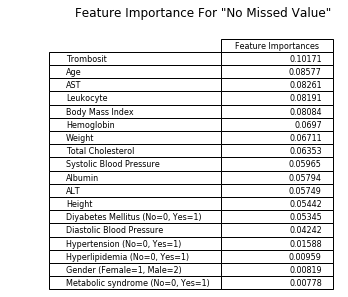

Index(['Trombosit', 'Age', 'AST', 'Leukocyte', 'Body Mass Index', 'Hemoglobin',
       'Weight', 'Total Cholesterol', 'Systolic Blood Pressure', 'Albumin'],
      dtype='object')

In [9]:
# with height and weight column
X_train, X_test, y_train, y_test = train_test_split(height_and_weight.values, targets_df.iloc[:,1].values,
                                        test_size = 0.2, random_state = 0, stratify=targets_df.iloc[:,1].values)

feature_importance_table(height_and_weight.columns, X_train, y_train, title="No Missed Value")

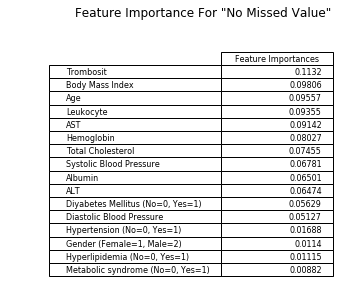

In [10]:
X_train, X_test, y_train, y_test = train_test_split(baseline2.values, targets_df.iloc[:,1].values,
                                        test_size = 0.2, random_state = 0, stratify=targets_df.iloc[:,1].values)

top_baseline_columns = list(feature_importance_table(baseline2.columns, X_train, y_train, title="No Missed Value"))

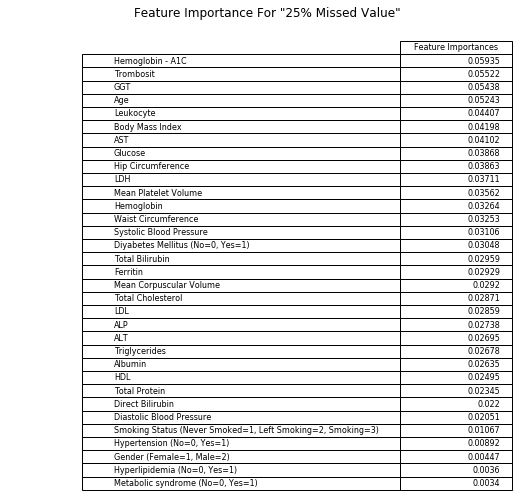

In [12]:
X_train, X_test, y_train, y_test = train_test_split(knn_25, targets_df.iloc[:,1].values,
                                        test_size = 0.2, random_state = 0, stratify=targets_df.iloc[:,1].values)

top_25_columns = list(feature_importance_table(threshold_25_df.columns, X_train, y_train, title="25% Missed Value"))

## Loading Models

In [13]:
def k_based_models(X, y):
    bagging = BaggingClassifier(DecisionTreeClassifier(), n_jobs=-1, random_state=1)
    # Finding Best Estimators
    estimators = best_estimator(X, y)

    # Organizing Them
    lr_best_af, svm_best_af, rf_best_af = estimators[0], estimators[1], estimators[2]

    af_models = [lr_best_af, svm_best_af, rf_best_af, bagging]
    return af_models

In [14]:
models = {'0':{}, '25':{}}

In [15]:
comparison_table = {}
kf = StratifiedKFold(10, random_state=1)
y = targets_df.iloc[:,1].values

for idx in range(10):
    k = idx+1
    X = baseline2[top_baseline_columns[:k]].values
    comparison_table.setdefault(k, [])
    af_models = k_based_models(X, y)
    models['0'][k] = af_models
    for mdl in af_models:
        avrg = []
        for train_index, test_index in kf.split(X, y):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
            avrg.append(collect_scores(mdl, X_train, X_test, y_train, y_test))
        avrg = pd.DataFrame(np.array(avrg)).replace({np.inf:np.nan}).values
        avrg_list = np.round(np.nanmean(avrg, axis=0, dtype=np.float64),3).tolist()
        avrg_list[0], avrg_list[1] = round(avrg_list[0]*100), round(avrg_list[1]*100)
        avrg_list[2], avrg_list[3] = avrg_list[2], avrg_list[3]
        comparison_table[k].append(avrg_list)

In [16]:
columns = ['Sensitivity (%)', 'Specificity (%)', 'FN', 'FP', 'PPV', 'NPV', 'PLR', 'NLR', 'AUC']
index = ['LR', 'SVM', 'RandomForest', 'Bagging']
tuples = [('K{}'.format(k), str(value)) for k in range(1,11) for value in index]
index1 = pd.MultiIndex.from_tuples(tuples)
af_table_df = pd.DataFrame(np.vstack([np.array(comparison_table[i]) for i in range(1,11)]), index=index1, columns=columns)
af_table_df

Sensitivity (%)  Specificity (%)     FN     FP    PPV  \
K1  LR                        0.0            100.0  0.179  0.000    NaN   
    SVM                      19.0             93.0  0.146  0.058  0.303   
    RandomForest             13.0             97.0  0.156  0.028  0.488   
    Bagging                  20.0             85.0  0.142  0.119  0.253   
K2  LR                        3.0             99.0  0.174  0.007  0.333   
    SVM                      20.0             84.0  0.142  0.132  0.206   
    RandomForest             11.0             96.0  0.159  0.033  0.344   
    Bagging                  20.0             90.0  0.142  0.078  0.332   
K3  LR                       10.0             98.0  0.161  0.017  0.417   
    SVM                      26.0             86.0  0.132  0.113  0.290   
    RandomForest             18.0             96.0  0.146  0.037  0.577   
    Bagging                  21.0             93.0  0.141  0.055  0.384   
K4  LR                       11.0             98.0  0.159  0.018  0.422   
    SVM                      26.0             93.0  0.132  0.060  0.433   
    RandomForest             18.0             96.0  0.147  0.031  0.491   
    Bagging                  21.0             94.0  0.141  0.050  0.437   
K5  LR                       16.0             98.0  0.151  0.018  0.633   
    SVM                      30.0             89.0  0.126  0.091  0.371   
    RandomForest             16.0             96.0  0.151  0.035  0.477   
    Bagging                  21.0             94.0  0.141  0.045  0.458   
K6  LR                       18.0             98.0  0.147  0.015  0.737   
    SVM                      32.0             88.0  0.122  0.097  0.374   
    RandomForest             12.0             98.0  0.157  0.018  0.573   
    Bagging                  23.0             96.0  0.137  0.035  0.528   
K7  LR                       14.0             99.0  0.154  0.008  0.729   
    SVM                      38.0             86.0  0.111  0.113  0.375   
    RandomForest             10.0             97.0  0.161  0.025  0.408   
    Bagging                  22.0             96.0  0.141  0.032  0.513   
K8  LR                       17.0             98.0  0.149  0.017  0.612   
    SVM                      30.0             91.0  0.124  0.071  0.434   
    RandomForest             11.0             99.0  0.159  0.008  0.786   
    Bagging                  15.0             95.0  0.152  0.040  0.452   
K9  LR                       12.0             98.0  0.157  0.018  0.487   
    SVM                      37.0             92.0  0.112  0.065  0.524   
    RandomForest             10.0             98.0  0.161  0.020  0.442   
    Bagging                  18.0             95.0  0.147  0.038  0.532   
K10 LR                       11.0             98.0  0.159  0.018  0.450   
    SVM                      30.0             86.0  0.126  0.116  0.303   
    RandomForest             12.0             97.0  0.157  0.022  0.494   
    Bagging                  13.0             96.0  0.156  0.033  0.440   

                    NPV    PLR    NLR    AUC  
K1  LR            0.821    NaN  1.000  0.664  
    SVM           0.841  2.939  0.873  0.523  
    RandomForest  0.836  5.592  0.902  0.538  
    Bagging       0.831  1.680  0.940  0.494  
K2  LR            0.824  0.758  0.981  0.676  
    SVM           0.830  1.279  0.945  0.557  
    RandomForest  0.832  3.927  0.928  0.640  
    Bagging       0.839  3.016  0.886  0.608  
K3  LR            0.834  1.983  0.916  0.729  
    SVM           0.843  2.067  0.860  0.572  
    RandomForest  0.844  4.478  0.852  0.691  
    Bagging       0.845  3.779  0.848  0.656  
K4  LR            0.835  2.064  0.907  0.726  
    SVM           0.853  4.029  0.797  0.670  
    RandomForest  0.843  5.555  0.856  0.686  
    Bagging       0.846  4.229  0.839  0.663  
K5  LR            0.843  6.338  0.860  0.753  
    SVM           0.853  2.811  0.793  0.667  
    RandomForest  0.840  3.637  0.878  0.722  
  

## 25% Missed Value Top 10

In [17]:
comparison_table = {}
kf = StratifiedKFold(10, random_state=1)
y = targets_df.iloc[:,1].values

for idx in range(10):
    k = idx+1
    X = threshold_25_df[top_25_columns[:k]].values
    comparison_table.setdefault(k, [])
    af_models_25 = k_based_models(X, y)
    models['25'][k] = af_models_25
    for mdl in af_models_25:
        avrg = []
        for train_index, test_index in kf.split(X, y):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
            avrg.append(collect_scores(mdl, X_train, X_test, y_train, y_test))
        avrg = pd.DataFrame(np.array(avrg)).replace({np.inf:np.nan}).values
        avrg_list = np.round(np.nanmean(avrg, axis=0, dtype=np.float64),3).tolist()
        avrg_list[0], avrg_list[1] = round(avrg_list[0]*100), round(avrg_list[1]*100)
        avrg_list[2], avrg_list[3] = avrg_list[2], avrg_list[3]
        comparison_table[k].append(avrg_list)

In [18]:
columns = ['Sensitivity (%)', 'Specificity (%)', 'FN', 'FP', 'PPV', 'NPV', 'PLR', 'NLR', 'AUC']
index = ['LR', 'SVM', 'RandomForest', 'Bagging']
tuples = [('K{}'.format(k), str(value)) for k in range(1,11) for value in index]
index1 = pd.MultiIndex.from_tuples(tuples)
af_table_25_df = pd.DataFrame(np.vstack([np.array(comparison_table[i]) for i in range(1,11)]), index=index1, columns=columns)
af_table_25_df

Sensitivity (%)  Specificity (%)     FN     FP    PPV  \
K1  LR                        6.0             99.0  0.169  0.007  0.550   
    SVM                      29.0             89.0  0.127  0.089  0.394   
    RandomForest             14.0             95.0  0.154  0.041  0.479   
    Bagging                  16.0             91.0  0.151  0.071  0.268   
K2  LR                       10.0             98.0  0.161  0.015  0.600   
    SVM                      20.0             87.0  0.142  0.108  0.264   
    RandomForest             10.0             95.0  0.161  0.042  0.352   
    Bagging                  22.0             89.0  0.139  0.091  0.312   
K3  LR                       13.0             98.0  0.156  0.018  0.500   
    SVM                      28.0             82.0  0.129  0.146  0.252   
    RandomForest             19.0             96.0  0.145  0.033  0.501   
    Bagging                  23.0             94.0  0.137  0.051  0.426   
K4  LR                       20.0             97.0  0.144  0.027  0.636   
    SVM                      24.0             92.0  0.136  0.063  0.415   
    RandomForest             21.0             95.0  0.142  0.042  0.499   
    Bagging                  24.0             92.0  0.136  0.066  0.425   
K5  LR                       19.0             97.0  0.146  0.027  0.621   
    SVM                      26.0             89.0  0.132  0.093  0.327   
    RandomForest             20.0             97.0  0.144  0.025  0.606   
    Bagging                  24.0             93.0  0.137  0.058  0.454   
K6  LR                       26.0             96.0  0.132  0.033  0.594   
    SVM                      30.0             88.0  0.124  0.098  0.361   
    RandomForest             24.0             96.0  0.137  0.030  0.629   
    Bagging                  28.0             94.0  0.129  0.050  0.499   
K7  LR                       25.0             97.0  0.134  0.028  0.641   
    SVM                      27.0             94.0  0.131  0.053  0.479   
    RandomForest             22.0             97.0  0.140  0.022  0.687   
    Bagging                  24.0             94.0  0.136  0.047  0.437   
K8  LR                       31.0             95.0  0.124  0.040  0.632   
    SVM                      31.0             94.0  0.124  0.046  0.522   
    RandomForest             20.0             97.0  0.144  0.022  0.633   
    Bagging                  23.0             94.0  0.137  0.047  0.500   
K9  LR                       32.0             94.0  0.122  0.048  0.553   
    SVM                      34.0             89.0  0.119  0.088  0.422   
    RandomForest             18.0             98.0  0.147  0.018  0.681   
    Bagging                  23.0             94.0  0.137  0.050  0.463   
K10 LR                       33.0             94.0  0.121  0.046  0.579   
    SVM                      34.0             93.0  0.119  0.060  0.504   
    RandomForest             14.0             97.0  0.154  0.022  0.583   
    Bagging                  24.0             95.0  0.136  0.043  0.490   

                    NPV     PLR    NLR    AUC  
K1  LR            0.829   5.791  0.951  0.690  
    SVM           0.853   2.986  0.803  0.463  
    RandomForest  0.835   3.998  0.905  0.664  
    Bagging       0.833   2.004  0.922  0.627  
K2  LR            0.834   5.710  0.915  0.726  
    SVM           0.833   2.692  0.927  0.555  
    RandomForest  0.829   2.258  0.947  0.695  
    Bagging       0.840   2.329  0.875  0.646  
K3  LR            0.838   6.128  0.890  0.739  
    SVM           0.840   1.670  0.881  0.451  
    RandomForest  0.845   4.362  0.843  0.724  
    Bagging       0.849   4.264  0.818  0.682  
K4  LR            0.847   7.984  0.830  0.768  
    SVM           0.849   4.234  0.818  0.565  
    RandomForest  0.846   5.983  0.836  0.734  
    Bagging       0.848   4.306  0.822  0.690  
K5  LR            0.846   7.154  0.839  0.763  
    SVM           0.847   2.321  0.832  0.613  
    RandomForest  0.847   7.95

In [19]:
with open('topk_features_models_without_additional_columns.db','wb') as file:
    pickle.dump(models, file)

In [6]:
import matplotlib.patches as mpatches
matrices_0 = pd.read_excel('matrices_0_2.xlsx')
matrices_25 = pd.read_excel('matrices_25_2.xlsx')
model_names = matrices_0["Unnamed: 1"].unique()
colors = ['r', 'g', 'b', 'purple']

In [7]:
auc_scores = {'0':{}, '25':{}}

for mdl_name in model_names:
    auc_scores['0'][mdl_name] = matrices_0[matrices_0['Unnamed: 1'] == mdl_name]['AUC'].values
    auc_scores['25'][mdl_name] = matrices_25[matrices_25['Unnamed: 1'] == mdl_name]['AUC'].values

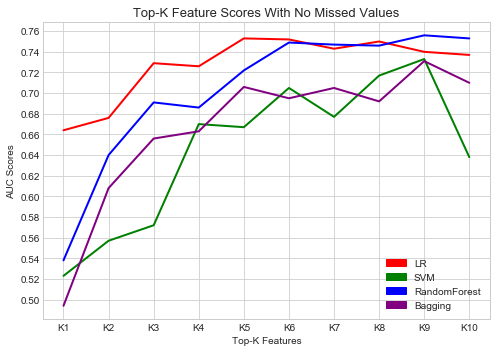

In [8]:
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(7,5))
plt.yticks(np.arange(0.4, 0.84, 0.02))

legends = []
for i in range(len(model_names)):
    plt.plot(['K{}'.format(c) for c in range(1,11)],
            auc_scores["0"][model_names[i]],
            color = colors[i], linewidth=2)
    legends.append(mpatches.Patch(color=colors[i], label=model_names[i]))
plt.legend(handles=legends,loc='best')
plt.title('Top-K Feature Scores With No Missed Values', size=13)
plt.xlabel('Top-K Features'); plt.ylabel('AUC Scores')

plt.tight_layout()
plt.show()
# plt.savefig('linechart_0threshold_no4clm.png', dpi=300, bbox_inches='tight')

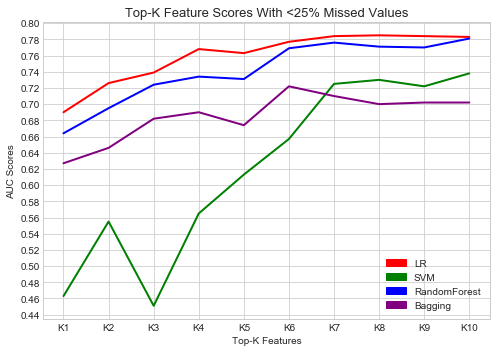

In [9]:
plt.figure(figsize=(7,5))
# plt.ylim([0.5,0.85])
plt.yticks(np.arange(0.4, 0.84, 0.02))

legends = []
for i in range(len(model_names)):
    plt.plot(['K{}'.format(i) for i in range(1,11)],
            auc_scores["25"][model_names[i]],
            color = colors[i], linewidth=2)
    legends.append(mpatches.Patch(color=colors[i], label=model_names[i]))
plt.legend(handles=legends,loc='best')
plt.title('Top-K Feature Scores With <25% Missed Values', size=13)
plt.xlabel('Top-K Features'); plt.ylabel('AUC Scores')

plt.tight_layout()
# plt.savefig('linechart_25threshold_no4clm.png', dpi=300, bbox_inches='tight')